In [1]:
from os.path import join
import numpy as np
import torch
import matplotlib.pyplot as plt

from cytoself.datamanager.opencell import DataManagerOpenCell
from cytoself.trainer.cytoselflite_trainer import CytoselfFullTrainer
from cytoself.analysis.analysis_opencell import AnalysisOpenCell
from cytoself.trainer.utils.plot_history import plot_history_cytoself

data_ch = ['pro', 'nuc'] # , 'nucdist', 'label']
# datapath = '/home/ec2-user/cytoself-data'
datapath = 'sample_data'

datamanager = DataManagerOpenCell(datapath, data_ch, fov_col=None)
datamanager.const_dataloader(batch_size=32, label_name_position=1)

Loading pro data...


100%|██████████| 9/9 [00:00<00:00, 13.27it/s]


Loading nuc data...


100%|██████████| 9/9 [00:00<00:00, 279.68it/s]


Loading label data...


100%|██████████| 9/9 [00:00<00:00, 1881.04it/s]


Splitting data...
Computing variance of training data...
Computing variance of validation data...
Computing variance of test data...


In [14]:
model_args = {
    'input_shape': (2, 100, 100),
    'emb_shapes': ((25, 25), (4, 4)),
    'output_shape': (2, 100, 100),
    'fc_output_idx': [2],
    'vq_args': {'num_embeddings': 512, 'embedding_dim': 64},
    'num_class': len(datamanager.unique_labels),
    'fc_input_type': 'vqvec',
}
train_args = {
    'lr': 1e-3,
    'max_epoch': 100,
    'reducelr_patience': 3,
    'reducelr_increment': 0.1,
    'earlystop_patience': 60,
}
trainer = CytoselfFullTrainer(train_args, homepath='demo_output', model_args=model_args)
trainer.fit(datamanager, tensorboard_path='tb_logs')

/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


Epoch 1/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.43it/s]


A model checkpoint has been saved at demo_output/checkpoints/checkpoint_ep1.chkp
Epoch 2/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.68it/s]


A model checkpoint has been saved at demo_output/checkpoints/checkpoint_ep2.chkp
Epoch 3/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.31it/s]


Epoch 4/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.31it/s]


Epoch 5/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.58it/s]


learn rate =  0.0001
Epoch 6/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 7/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 8/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.98it/s]


learn rate =  1e-05
Epoch 9/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 10/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.95it/s]


Epoch 11/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.52it/s]


learn rate =  1.0000000000000002e-06
Epoch 12/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.95it/s]


Epoch 13/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 14/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.86it/s]


learn rate =  1.0000000000000002e-07
Epoch 15/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 11.03it/s]


Epoch 16/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 17/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.83it/s]


learn rate =  1.0000000000000004e-08
Epoch 18/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 19/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 20/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.49it/s]


learn rate =  1.0000000000000005e-09
Epoch 21/100


  Val: 100%|██████████| 5/5 [00:00<00:00,  9.47it/s]


Epoch 22/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 23/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 24/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 25/100


  Val: 100%|██████████| 5/5 [00:00<00:00,  9.76it/s]


Epoch 26/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 27/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 28/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 29/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch 30/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.32it/s]


Epoch 31/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 32/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 33/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 34/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 35/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 36/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 37/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.06it/s]


Epoch 38/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.46it/s]


Epoch 39/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 40/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 41/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 42/100


  Val: 100%|██████████| 5/5 [00:00<00:00,  9.88it/s]


Epoch 43/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 44/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 45/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 11.02it/s]


Epoch 46/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 47/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.19it/s]


Epoch 48/100


  Val: 100%|██████████| 5/5 [00:00<00:00,  9.90it/s]


Epoch 49/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 50/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 51/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 52/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.26it/s]


Epoch 53/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.00it/s]


Epoch 54/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 55/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 56/100


  Val: 100%|██████████| 5/5 [00:00<00:00,  9.33it/s]


Epoch 57/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 58/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 59/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 60/100


  Val: 100%|██████████| 5/5 [00:00<00:00,  9.65it/s]


Epoch 61/100


  Val: 100%|██████████| 5/5 [00:00<00:00,  9.93it/s]


Epoch 62/100


  Val: 100%|██████████| 5/5 [00:00<00:00, 10.32it/s]


Early stopping.


 Test: 100%|██████████| 4/4 [00:00<00:00, 10.34it/s]


A model has been saved at demo_output/model_62.pt


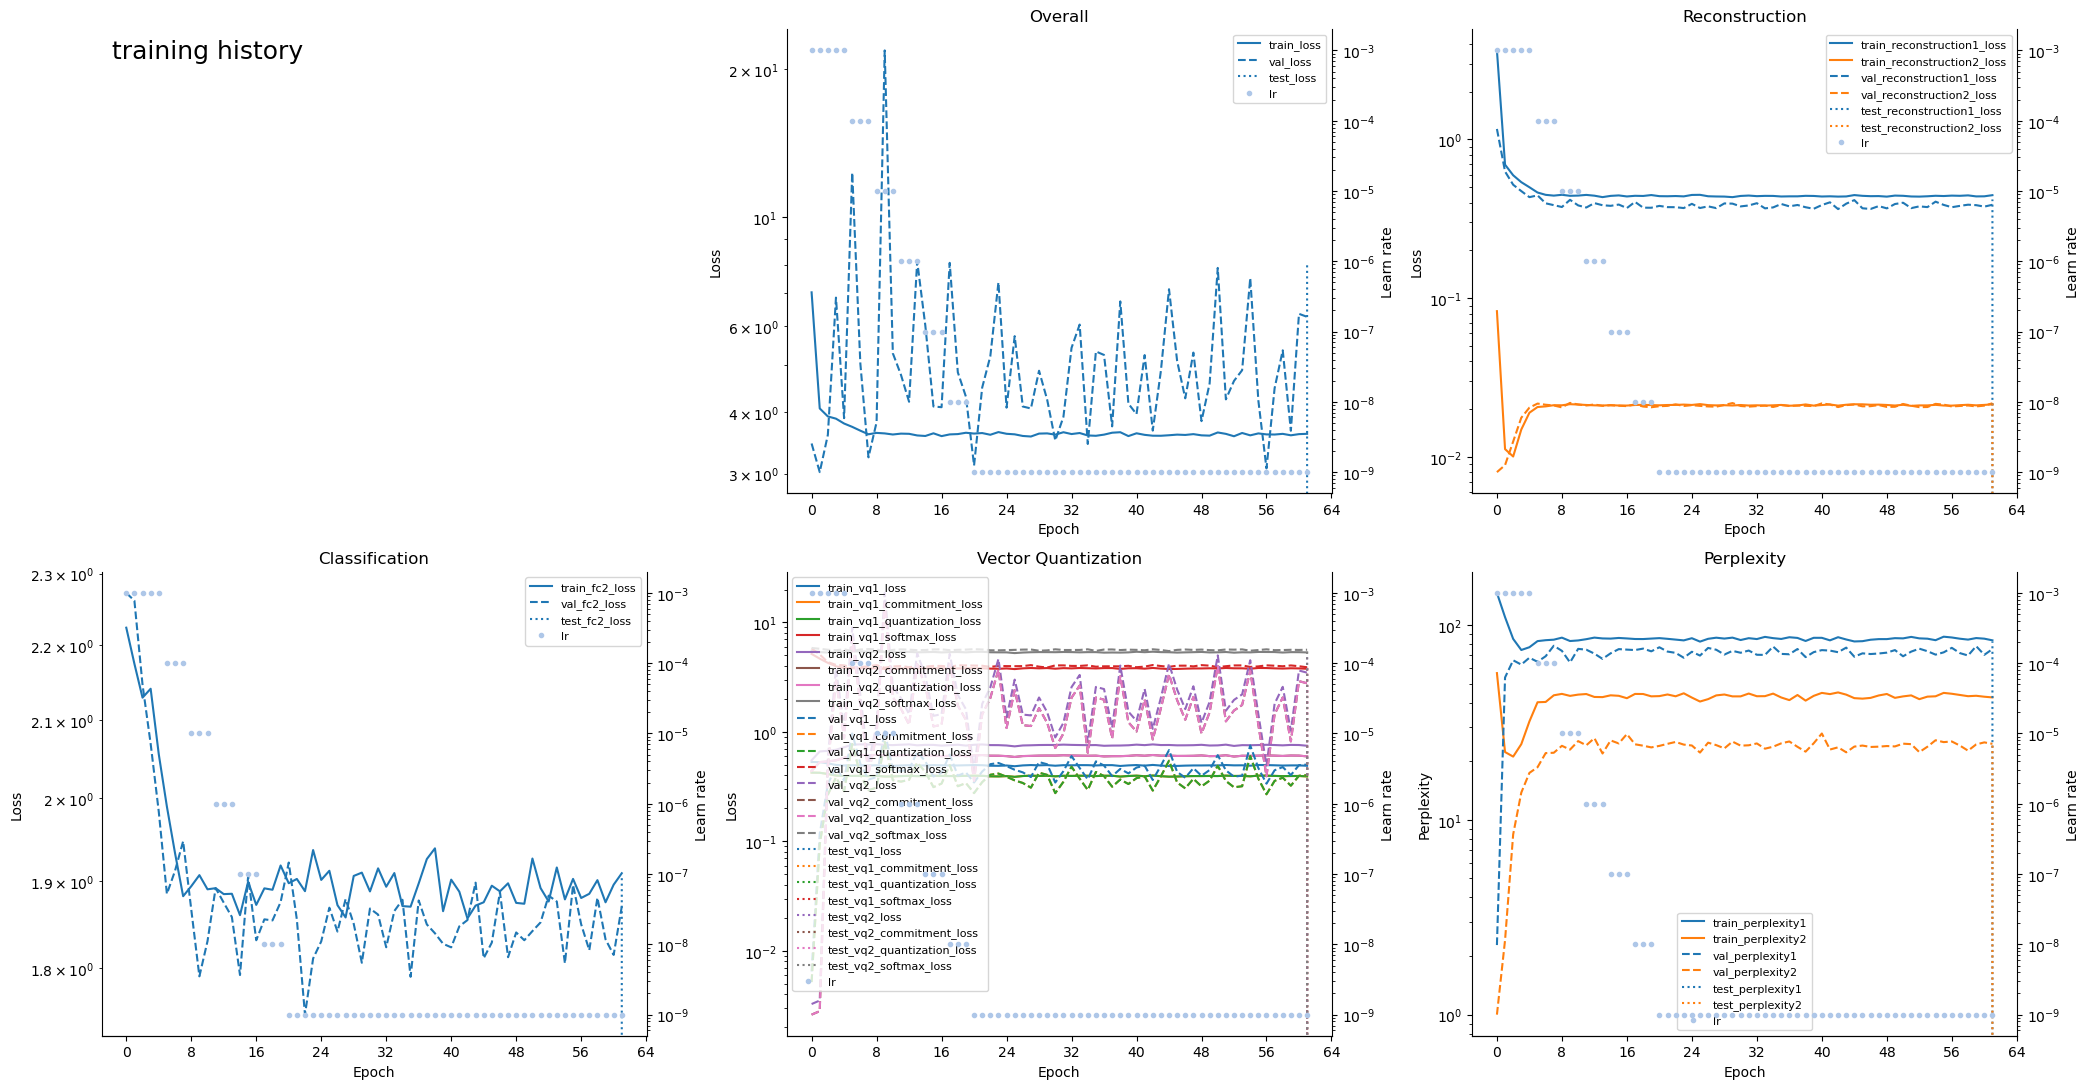

In [15]:
plot_history_cytoself(trainer.history, savepath=trainer.savepath_dict['visualization'])

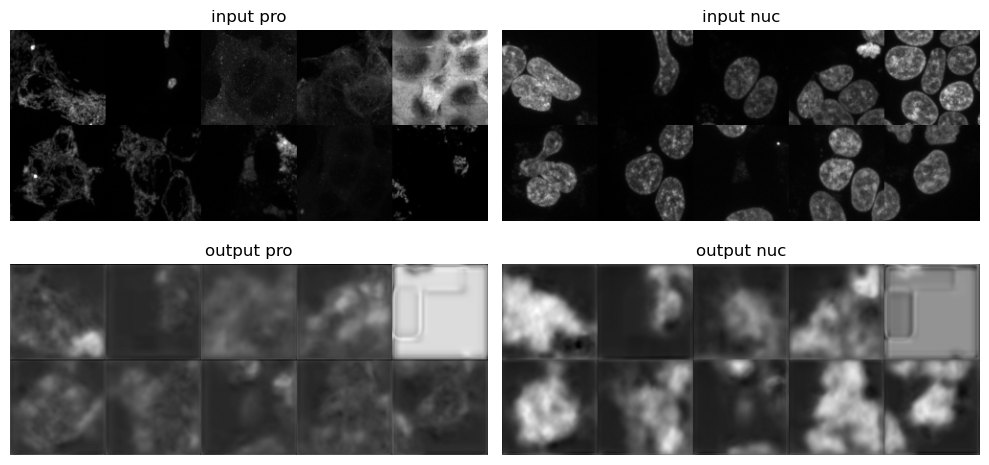

In [16]:
img = next(iter(datamanager.test_loader))['image'].detach().cpu().numpy()
torch.cuda.empty_cache()
reconstructed = trainer.infer_reconstruction(img)
fig, ax = plt.subplots(2, len(data_ch), figsize=(5 * len(data_ch), 5), squeeze=False)
for ii, ch in enumerate(data_ch):
    t0 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(img[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t0[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    t1 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(reconstructed[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t1[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    ax[0, ii].imshow(t0, cmap='gray')
    ax[0, ii].axis('off')
    ax[0, ii].set_title('input ' + ch)
    ax[1, ii].imshow(t1, cmap='gray')
    ax[1, ii].axis('off')
    ax[1, ii].set_title('output ' + ch)
fig.tight_layout()
fig.show()
fig.savefig(join(trainer.savepath_dict['visualization'], 'reconstructed_images.png'), dpi=300)

In [5]:
analysis = AnalysisOpenCell(datamanager, trainer)

Infer: 100%|██████████| 4/4 [00:00<00:00, 11.43it/s]


Computing cell line ID vs vq index...


100%|██████████| 9/9 [00:00<00:00, 6526.41it/s]


Computing self Pearson correlation...


  0%|          | 0/512 [00:00<?, ?it/s]/opt/conda/envs/pytorch/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|██████████| 512/512 [00:09<00:00, 53.86it/s] 
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


computing clustermaps...


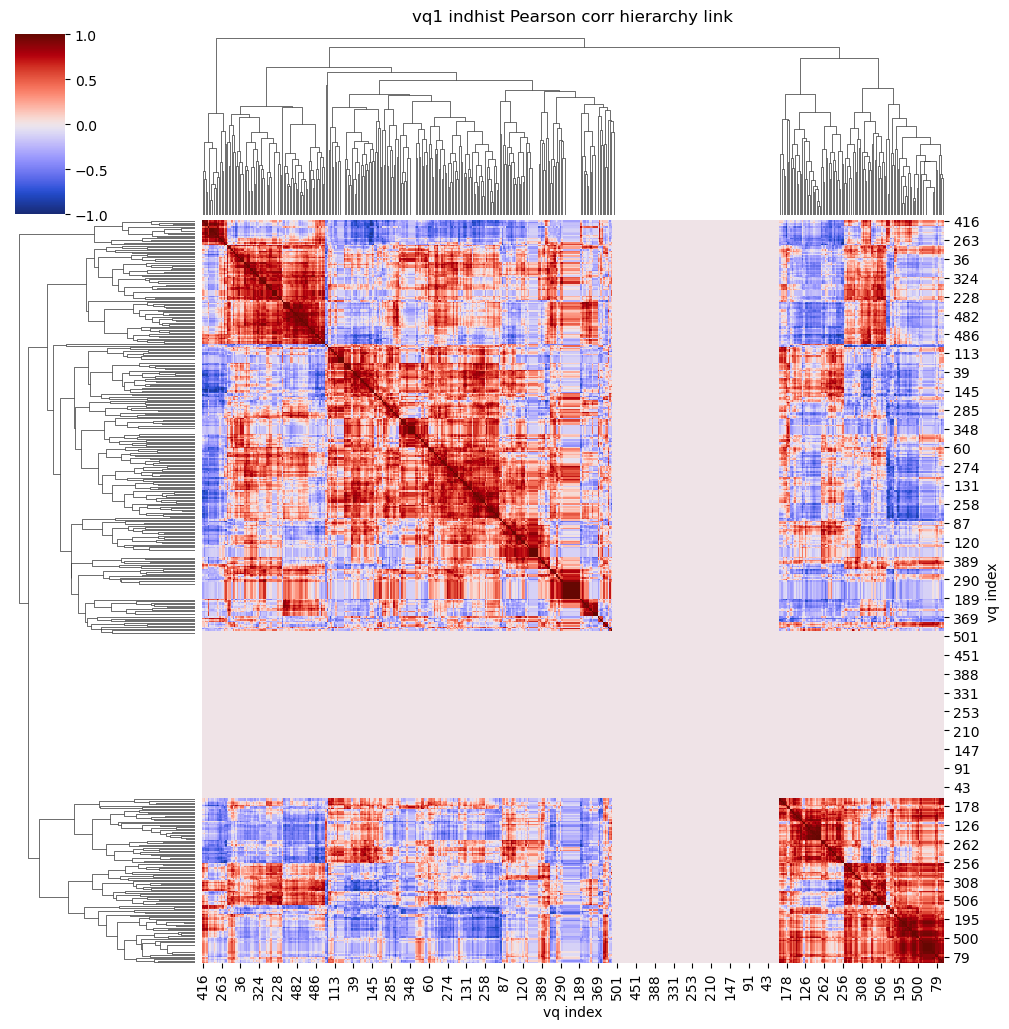

In [7]:
analysis.plot_clustermap(num_workers=4)

Computing embeddings from image...


Infer: 100%|██████████| 4/4 [00:00<00:00, 12.60it/s]

embeddings vqvec2 have been saved at demo_output/embeddings
Computing UMAP coordinates from embeddings...
UMAP( verbose=True)
Fri Jul 14 02:27:39 2023 Construct fuzzy simplicial set
Fri Jul 14 02:27:39 2023 Finding Nearest Neighbors
Fri Jul 14 02:27:39 2023 Finished Nearest Neighbor Search
Fri Jul 14 02:27:39 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Jul 14 02:27:42 2023 Finished embedding


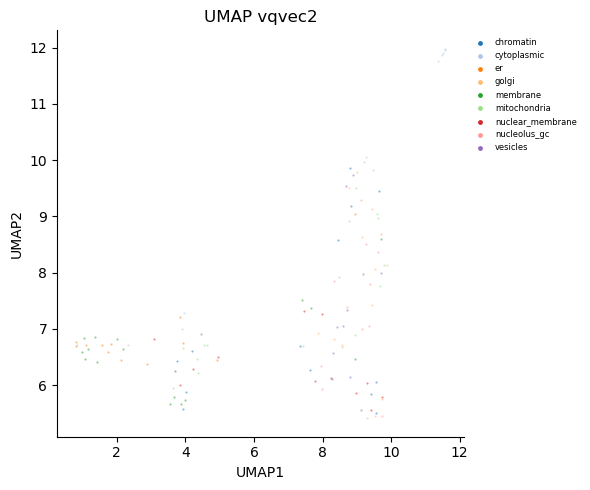

In [17]:
from cytoself.analysis.analysis_opencell import AnalysisOpenCell

analysis = AnalysisOpenCell(datamanager, trainer)
umap_data = analysis.plot_umap_of_embedding_vector(
    data_loader=datamanager.test_loader,
    group_col=2,
    output_layer=f'{model_args["fc_input_type"]}2',
    title=f'UMAP {model_args["fc_input_type"]}2',
    xlabel='UMAP1',
    ylabel='UMAP2',
    s=0.3,
    alpha=0.5,
    show_legend=True,
)

Computing embeddings from image...


Infer: 100%|██████████| 4/4 [00:00<00:00, 12.68it/s]

embeddings vqvec2 have been saved at demo_output/embeddings
Computing UMAP coordinates from embeddings...
UMAP( verbose=True)
Fri Jul 14 02:27:43 2023 Construct fuzzy simplicial set
Fri Jul 14 02:27:43 2023 Finding Nearest Neighbors
Fri Jul 14 02:27:43 2023 Finished Nearest Neighbor Search
Fri Jul 14 02:27:43 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Jul 14 02:27:46 2023 Finished embedding


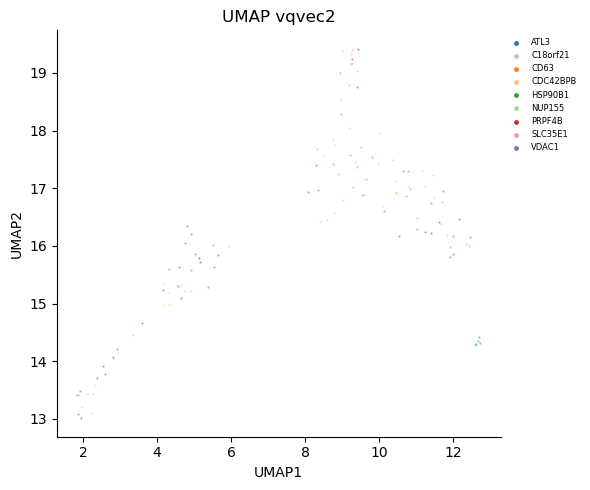

In [18]:
from cytoself.analysis.analysis_opencell import AnalysisOpenCell

analysis = AnalysisOpenCell(datamanager, trainer)
umap_data = analysis.plot_umap_of_embedding_vector(
    data_loader=datamanager.test_loader,
    group_col=1,
    output_layer=f'{model_args["fc_input_type"]}2',
    title=f'UMAP {model_args["fc_input_type"]}2',
    xlabel='UMAP1',
    ylabel='UMAP2',
    s=0.3,
    alpha=0.5,
    show_legend=True,
)

Infer: 100%|██████████| 4/4 [00:00<00:00, 11.30it/s]


Computing cell line ID vs vq index...


100%|██████████| 9/9 [00:00<00:00, 8766.54it/s]


Computing self Pearson correlation...


  0%|          | 0/512 [00:00<?, ?it/s]/opt/conda/envs/pytorch/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|██████████| 512/512 [00:09<00:00, 53.98it/s] 
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


computing clustermaps...


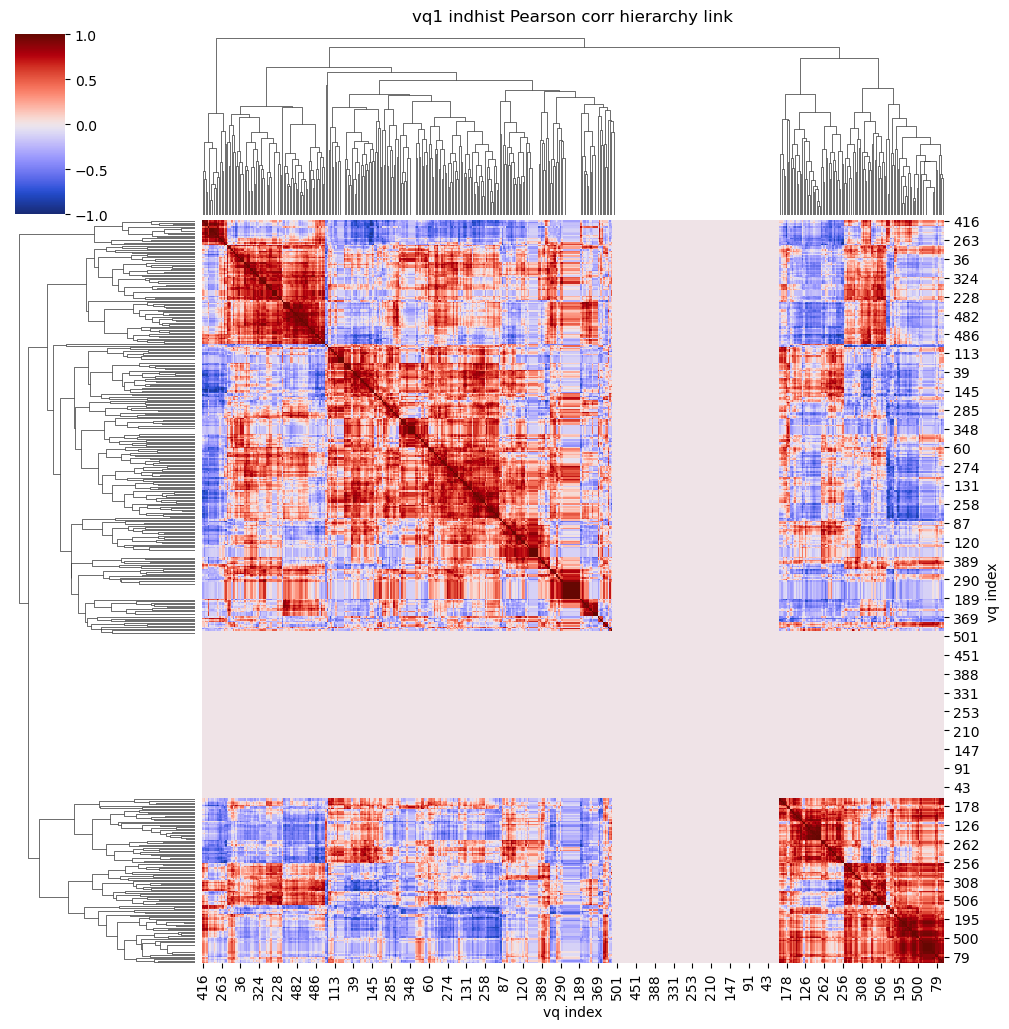

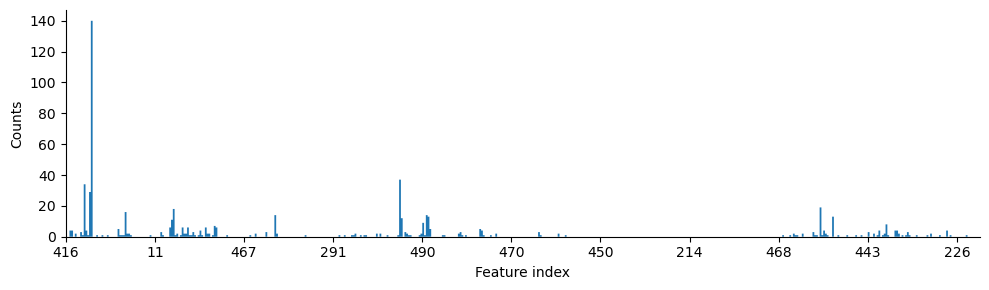

In [9]:
# Compute bi-clustering heatmap
analysis.plot_clustermap(num_workers=4)

# Prepare image data
img = next(iter(datamanager.test_loader))['image'].detach().cpu().numpy()[:1]

# Compute index histogram
vqindhist1 = trainer.infer_embeddings(img, 'vqindhist1')

# Reorder the index histogram according to the bi-clustering heatmap
ft_spectrum = analysis.compute_feature_spectrum(vqindhist1)

# Generate a plot
import numpy as np
import matplotlib.pyplot as plt

x_max = ft_spectrum.shape[1] + 1
x_ticks = np.arange(0, x_max, 50)
fig, ax = plt.subplots(figsize=(10, 3))
ax.stairs(ft_spectrum[0], np.arange(x_max), fill=True)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('Feature index')
ax.set_ylabel('Counts')
ax.set_xlim([0, x_max])
ax.set_xticks(x_ticks, analysis.feature_spectrum_indices[x_ticks])
fig.tight_layout()
fig.show()

### Custom umap

In [12]:
batch = next(iter(datamanager.test_loader))

In [18]:
batch['image'].shape

torch.Size([32, 2, 100, 100])

In [19]:
batch['label'].shape

torch.Size([32])

In [26]:
output = trainer.model(batch['image'].to('cuda'), 'vqvec2')

In [31]:
import torch
from tqdm import tqdm


trainer.model.to('cuda')
embeddings = []
for batch in tqdm(datamanager.test_loader):
    emb = trainer.model(batch['image'].to('cuda'), 'vqvec2')
    embeddings.append(emb.detach().cpu().numpy())
embeddings = np.concatenate(embeddings, axis=0)

100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


In [32]:
embeddings.shape

(119, 64, 4, 4)

In [33]:
import umap


n_neighbors = 15
min_dist = 0.1
metric = 'euclidean'
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
reducer.fit(embeddings.reshape(embeddings.shape[0], -1))

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [34]:
reduced_embedding = reducer.transform(embeddings.reshape(embeddings.shape[0], -1))

In [40]:
labels = list(datamanager.test_loader.dataset.label[:, 2])

In [41]:
labels

['mitochondria',
 'nucleolus_gc',
 'membrane',
 'er',
 'cytoplasmic',
 'mitochondria',
 'mitochondria',
 'vesicles',
 'membrane',
 'golgi',
 'chromatin',
 'vesicles',
 'er',
 'nuclear_membrane',
 'cytoplasmic',
 'nucleolus_gc',
 'chromatin',
 'nucleolus_gc',
 'er',
 'nucleolus_gc',
 'membrane',
 'mitochondria',
 'cytoplasmic',
 'membrane',
 'mitochondria',
 'chromatin',
 'cytoplasmic',
 'er',
 'nucleolus_gc',
 'mitochondria',
 'er',
 'vesicles',
 'membrane',
 'vesicles',
 'golgi',
 'nuclear_membrane',
 'mitochondria',
 'cytoplasmic',
 'golgi',
 'nuclear_membrane',
 'mitochondria',
 'golgi',
 'membrane',
 'nucleolus_gc',
 'chromatin',
 'cytoplasmic',
 'mitochondria',
 'golgi',
 'membrane',
 'golgi',
 'membrane',
 'nucleolus_gc',
 'nuclear_membrane',
 'er',
 'golgi',
 'chromatin',
 'nuclear_membrane',
 'chromatin',
 'golgi',
 'er',
 'er',
 'chromatin',
 'er',
 'mitochondria',
 'nuclear_membrane',
 'membrane',
 'mitochondria',
 'chromatin',
 'chromatin',
 'vesicles',
 'cytoplasmic',
 'nuc

<AxesSubplot:>

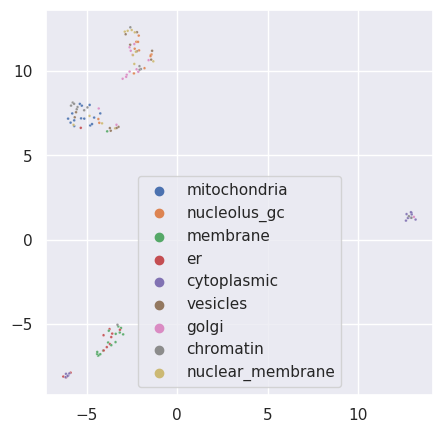

In [44]:
import seaborn as sns
sns.set(rc={"figure.figsize":(5, 5)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=labels, s=4, alpha=0.9)